In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

In [9]:
import math
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
class FPNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.next = None

    def __repr__(self):
        return f"{self.item}:{self.count}"

def insert_tree(items, node, header_table):
    """Insert the sorted frequent items of one transaction into the FP-tree."""
    if not items:
        return
    first_item = items[0]
    if first_item in node.children:
        node.children[first_item].count += 1
    else:
        new_node = FPNode(first_item, 1, node)
        node.children[first_item] = new_node

        if first_item in header_table:
            current = header_table[first_item]
            while current.next:
                current = current.next
            current.next = new_node
        else:
            header_table[first_item] = new_node

    insert_tree(items[1:], node.children[first_item], header_table)

def build_fp_tree_stepwise(transactions, min_support_count, color_map):
    """
    Build the FP-tree step by step, visualizing after each transaction insertion.
    """
    frequency = {}
    for trans in transactions:
        for item in trans:
            frequency[item] = frequency.get(item, 0) + 1

    frequency = {item: cnt for item, cnt in frequency.items() if cnt >= min_support_count}
    if not frequency:
        return None, None
    root = FPNode(None, 1, None)
    header_table = {}


    def sort_items(transaction):
        filtered = [item for item in transaction if item in frequency]
        filtered.sort(key=lambda x: (-frequency[x], x))
        return filtered

    for i, trans in enumerate(transactions, start=1):
        sorted_items = sort_items(trans)
        insert_tree(sorted_items, root, header_table)
        visualize_tree(root, color_map, title=f"After inserting T{i}: {trans}")

    return root, header_table

def traverse_tree(node, graph, color_map, parent_id=None):
    """Recursively add nodes and edges to the NetworkX graph."""
    node_id = id(node)
    label = "Root" if node.item is None else f"{node.item}:{node.count}"
    graph.add_node(node_id, label=label)

    node_color = color_map.get(node.item, "lightgray")
    nx.set_node_attributes(graph, {node_id: node_color}, "color")

    if parent_id is not None:
        graph.add_edge(parent_id, node_id)
    for child in node.children.values():
        traverse_tree(child, graph, color_map, node_id)

def visualize_tree(root, color_map, title="FP-Tree"):
    """Visualize the FP-tree using Graphviz's dot layout for a hierarchical appearance."""
    graph = nx.DiGraph()
    traverse_tree(root, graph, color_map)
    try:
        pos = nx.nx_agraph.graphviz_layout(graph, prog='dot')
    except Exception as e:
        print("Graphviz layout not available, using spring layout instead.")
        pos = nx.spring_layout(graph, seed=42)
    labels = nx.get_node_attributes(graph, "label")
    node_colors = [nx.get_node_attributes(graph, "color")[n] for n in graph.nodes()]
    plt.figure(figsize=(8, 6))
    nx.draw(graph, pos, with_labels=True, labels=labels,
            node_size=2000, node_color=node_colors,
            edge_color="gray", font_size=10, arrows=True)
    plt.title(title)
    plt.show()

def find_prefix_paths(item, node):
    """
    Collect prefix paths leading to each occurrence of 'item'.
    """
    paths = []
    while node:
        path = []
        parent = node.parent
        while parent is not None and parent.item is not None:
            path.append(parent.item)
            parent = parent.parent
        if path:
            path.reverse()  # Path from root to the node's parent.
            paths.append((path, node.count))
        node = node.next
    return paths

def insert_conditional_tree(items, node, header_table, count):
    """Insert items into the conditional FP-tree with a given count."""
    if not items:
        return
    first_item = items[0]
    if first_item in node.children:
        node.children[first_item].count += count
    else:
        new_node = FPNode(first_item, count, node)
        node.children[first_item] = new_node
        if first_item in header_table:
            current = header_table[first_item]
            while current.next:
                current = current.next
            current.next = new_node
        else:
            header_table[first_item] = new_node
    insert_conditional_tree(items[1:], node.children[first_item], header_table, count)

def build_conditional_tree(prefix_paths, min_support_count):
    """
    Build a conditional FP-tree from the given prefix paths.
    """
    frequency = {}
    for path, count in prefix_paths:
        for item in path:
            frequency[item] = frequency.get(item, 0) + count
    frequency = {item: cnt for item, cnt in frequency.items() if cnt >= min_support_count}
    if not frequency:
        return None, None
    root = FPNode(None, 1, None)
    header_table = {}
    for path, count in prefix_paths:
        filtered = [i for i in path if i in frequency]
        filtered.sort(key=lambda x: (-frequency[x], x))
        insert_conditional_tree(filtered, root, header_table, count)
    return root, header_table

def mine_fp_tree(root, header_table, min_support_count, prefix=None, freq_itemsets=None):
    """
    Recursively mine the FP-tree to extract frequent itemsets.
    """
    if prefix is None:
        prefix = []
    if freq_itemsets is None:
        freq_itemsets = []

    items = []
    for item, node in header_table.items():
        total_count = 0
        temp = node
        while temp:
            total_count += temp.count
            temp = temp.next
        items.append((item, total_count))
    items.sort(key=lambda x: x[1])

    for (item, support) in items:
        new_freq_set = prefix + [item]
        freq_itemsets.append((new_freq_set, support))
        prefix_paths = find_prefix_paths(item, header_table[item])
        cond_root, cond_header = build_conditional_tree(prefix_paths, min_support_count)
        if cond_root is not None:
            mine_fp_tree(cond_root, cond_header, min_support_count, new_freq_set, freq_itemsets)
    return freq_itemsets

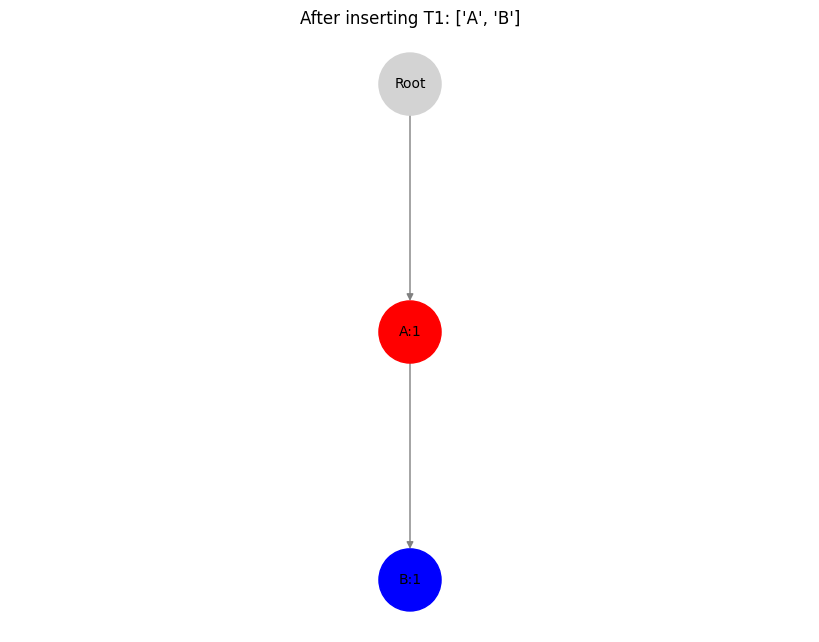

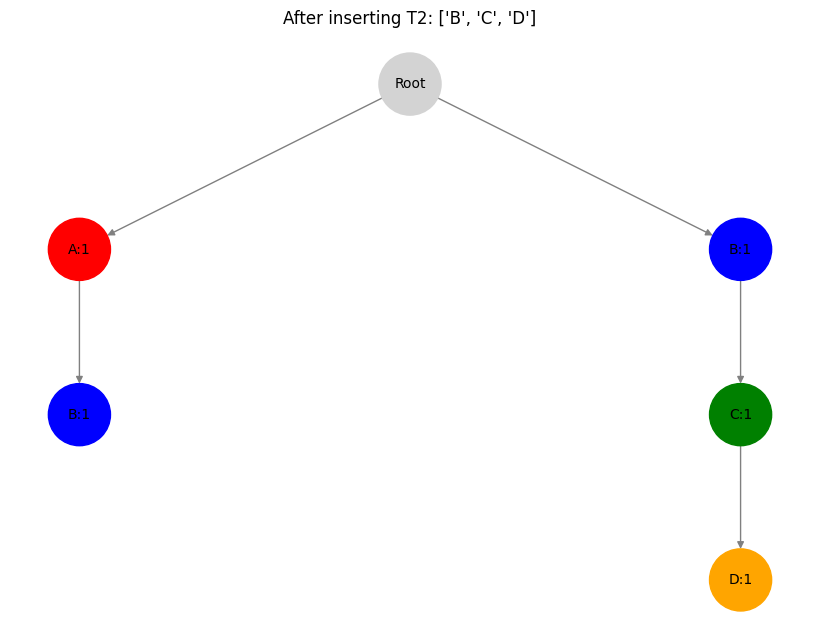

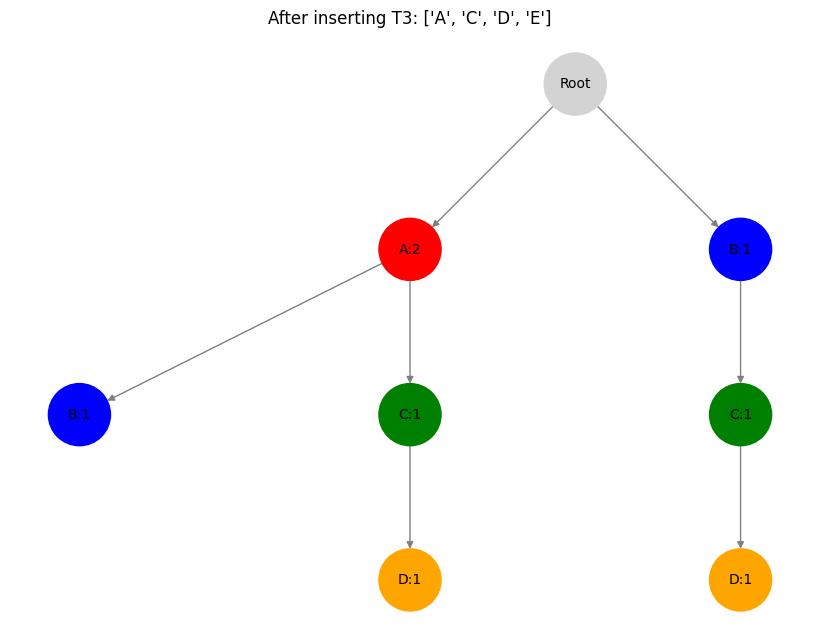


Frequent Itemsets (itemset, support_count):
['D', 'C'] -> 2
['A'] -> 2
['B'] -> 2
['C'] -> 2
['D'] -> 2


In [14]:
transactions = [
    ['A', 'B'],
    ['B', 'C', 'D'],
    ['A', 'C', 'D', 'E']
]

min_support_threshold = 0.5
min_support_count = math.ceil(min_support_threshold * len(transactions))

color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'orange',
    'E': 'purple',
    None: 'lightgray'
}

root, header_table = build_fp_tree_stepwise(transactions, min_support_count, color_map)

if root is None:
    print("No frequent items found for this support threshold.")
else:
    freq_itemsets = mine_fp_tree(root, header_table, min_support_count)

    print("\nFrequent Itemsets (itemset, support_count):")
    for itemset, count in sorted(freq_itemsets, key=lambda x: (-len(x[0]), x[0])):
        print(f"{itemset} -> {count}")
